In [0]:
import pyspark.sql.functions as F      # Import PySpark SQL functions for DataFrame operations
import numpy as np                    # Import NumPy for numerical operations
import pandas as pd                   # Import pandas for DataFrame manipulation
from xgboost import XGBClassifier     # Import XGBoost classifier for machine learning
from sklearn.metrics import roc_auc_score, average_precision_score  # Import metrics for model evaluation

label_col  = "DEP_DEL15"              # Define the label column name for classification
weight_col = "class_weight"           # Define the sample weight column name

# Load training data with weights from parquet file
train_w = spark.read.parquet("dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_weighted.parquet")
# Load validation data from parquet file
val     = spark.read.parquet("dbfs:/student-groups/Group_4_4/cp6_val_2018_refined.parquet")
# Load test data from parquet file
test    = spark.read.parquet("dbfs:/student-groups/Group_4_4/cp6_test_2019_refined.parquet")

# Print the number of rows in each dataset
for name, df in [("TRAIN_W", train_w), ("VAL", val), ("TEST", test)]:
    print(name, df.count())

TRAIN_W 16804556
VAL 7065328
TEST 7259007


In [0]:
gpu_feats = [
    # congestion / propagation
    "airport_traffic_density",
    "num_airport_wide_delays",
    "oncoming_flights",
    "time_based_congestion_ratio",
    "delay_propagation_score",
    "network_delay_cascade",
    "prior_day_delay_rate",
    "same_day_prior_delay_percentage",
    "origin_1yr_delay_rate",
    "dest_1yr_delay_rate",
    "dest_delay_rate_today",
    "rolling_30day_volume",
    "route_delay_rate_30d",
    "dep_delay15_24h_rolling_avg_by_origin_weighted",
    "dep_delay15_24h_rolling_avg_by_origin_carrier_weighted",

    # weather / location
    "HourlyVisibility",
    "HourlyWindGustSpeed",
    "HourlyRelativeHumidity",
    "origin_airport_lat", "origin_airport_lon",
    "dest_airport_lat",   "dest_airport_lon",
    "weather_x_airport_delays",

    # time encodings
    "dep_time_sin", "dep_time_cos",
    "day_of_week_sin", "day_of_week_cos",
    "month_sin",

    # indexed categoricals
    "DEST_indexed", "ORIGIN_indexed", "OP_UNIQUE_CARRIER_indexed",
]

# keep only those that actually exist in this dataset
gpu_feats = [c for c in gpu_feats if c in train_w.columns]
print("Using", len(gpu_feats), "GPU features.")
print(gpu_feats)


Using 31 GPU features.
['airport_traffic_density', 'num_airport_wide_delays', 'oncoming_flights', 'time_based_congestion_ratio', 'delay_propagation_score', 'network_delay_cascade', 'prior_day_delay_rate', 'same_day_prior_delay_percentage', 'origin_1yr_delay_rate', 'dest_1yr_delay_rate', 'dest_delay_rate_today', 'rolling_30day_volume', 'route_delay_rate_30d', 'dep_delay15_24h_rolling_avg_by_origin_weighted', 'dep_delay15_24h_rolling_avg_by_origin_carrier_weighted', 'HourlyVisibility', 'HourlyWindGustSpeed', 'HourlyRelativeHumidity', 'origin_airport_lat', 'origin_airport_lon', 'dest_airport_lat', 'dest_airport_lon', 'weather_x_airport_delays', 'dep_time_sin', 'dep_time_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'DEST_indexed', 'ORIGIN_indexed', 'OP_UNIQUE_CARRIER_indexed']


In [0]:
def make_small_stratified(df, label_col, cols,
                          n_pos, n_neg,
                          seed_pos=1, seed_neg=2):
    # Select positive samples, shuffle with seed, and limit to n_pos
    pos = (
        df.filter(F.col(label_col) == 1)
          .orderBy(F.rand(seed_pos))
          .limit(n_pos)
    )
    # Select negative samples, shuffle with seed, and limit to n_neg
    neg = (
        df.filter(F.col(label_col) == 0)
          .orderBy(F.rand(seed_neg))
          .limit(n_neg)
    )
    # Combine positive and negative samples, select only specified columns
    return pos.unionByName(neg).select(*cols)

# Define columns to keep for each split
train_cols = gpu_feats + [label_col, weight_col]
val_cols   = gpu_feats + [label_col]
test_cols  = gpu_feats + [label_col]

# Create a small stratified training sample with 8000 positives and 17000 negatives
train_small = make_small_stratified(train_w, label_col, train_cols,
                                    n_pos=8000, n_neg=17000,
                                    seed_pos=11, seed_neg=12)

# Create a small stratified validation sample with 4000 positives and 8000 negatives
val_small   = make_small_stratified(val,      label_col, val_cols,
                                    n_pos=4000, n_neg=8000,
                                    seed_pos=21, seed_neg=22)

# Create a small stratified test sample with 4000 positives and 8000 negatives
test_small  = make_small_stratified(test,     label_col, test_cols,
                                    n_pos=4000, n_neg=8000,
                                    seed_pos=31, seed_neg=32)

# Convert Spark DataFrames to pandas DataFrames for downstream use
train_pdf = train_small.toPandas()
val_pdf   = val_small.toPandas()
test_pdf  = test_small.toPandas()

# Print the shapes of the resulting pandas DataFrames
print("Shapes: train / val / test")
print(train_pdf.shape, val_pdf.shape, test_pdf.shape)
# Print the positive class rate (delay rate) for each split
print("Train delay rate:", train_pdf[label_col].mean())
print("Val delay rate:",   val_pdf[label_col].mean())
print("Test delay rate:",  test_pdf[label_col].mean())

Shapes: train / val / test
(25000, 33) (12000, 32) (12000, 32)
Train delay rate: 0.32
Val delay rate: 0.3333333333333333
Test delay rate: 0.3333333333333333


In [0]:
# Extract feature matrix and target/weight arrays from pandas DataFrames for training, validation, and test splits

# Training set: features, labels, and sample weights
X_train = train_pdf[gpu_feats].values
y_train = train_pdf[label_col].astype(int).values
w_train = train_pdf[weight_col].astype(float).values

# Validation set: features and labels
X_val   = val_pdf[gpu_feats].values
y_val   = val_pdf[label_col].astype(int).values

# Test set: features and labels
X_test  = test_pdf[gpu_feats].values
y_test  = test_pdf[label_col].astype(int).values

# Show shapes of feature matrices for each split
X_train.shape, X_val.shape, X_test.shape

((25000, 31), (12000, 31), (12000, 31))

In [0]:
def f2_score_np(y_true, y_pred_bin, beta=2.0):
    # Convert inputs to integer arrays
    y_true = y_true.astype(int)
    y_pred_bin = y_pred_bin.astype(int)

    # Calculate true positives, false positives, and false negatives
    tp = ((y_true == 1) & (y_pred_bin == 1)).sum()
    fp = ((y_true == 0) & (y_pred_bin == 1)).sum()
    fn = ((y_true == 1) & (y_pred_bin == 0)).sum()

    # Compute precision and recall with small epsilon to avoid division by zero
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)

    # Calculate F-beta score (default beta=2 for F2 score)
    beta2 = beta ** 2
    f2 = (1 + beta2) * precision * recall / (beta2 * precision + recall + 1e-12)
    # Return F2 score, precision, and recall as floats
    return float(f2), float(precision), float(recall)

In [0]:
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
pos_weight

2.125

In [0]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_score, recall_score, fbeta_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

param_grid = [
  {"max_depth": 3, "eta": 0.1,  "min_child_weight": 10, "subsample": 0.7, "colsample_bytree": 0.7, "reg_lambda": 5.0,  "reg_alpha": 0.0},
  {"max_depth": 3, "eta": 0.1,  "min_child_weight": 20, "subsample": 0.7, "colsample_bytree": 0.7, "reg_lambda": 5.0,  "reg_alpha": 0.0},
  {"max_depth": 4, "eta": 0.1,  "min_child_weight": 10, "subsample": 0.7, "colsample_bytree": 0.7, "reg_lambda": 5.0,  "reg_alpha": 0.0},
  {"max_depth": 4, "eta": 0.05, "min_child_weight": 10, "subsample": 0.7, "colsample_bytree": 0.7, "reg_lambda": 10.0, "reg_alpha": 0.0},
  {"max_depth": 4, "eta": 0.1,  "min_child_weight": 10, "subsample": 0.6, "colsample_bytree": 0.6, "reg_lambda": 5.0,  "reg_alpha": 0.0},
  {"max_depth": 3, "eta": 0.1,  "min_child_weight": 10, "subsample": 0.8, "colsample_bytree": 0.6, "reg_lambda": 5.0,  "reg_alpha": 0.1},
]

all_runs = []

for i, params in enumerate(param_grid):
    print(
        f"\n=== RUN {i} | depth={params['max_depth']} | eta={params['eta']} "
        f"| mcw={params['min_child_weight']} | subs={params['subsample']} "
        f"| col={params['colsample_bytree']} | l2={params['reg_lambda']} | l1={params['reg_alpha']} ==="
    )

    xgb = XGBClassifier(
        objective="binary:logistic",
        tree_method="hist",
        device="cuda",
        n_estimators=200,
        max_depth=params["max_depth"],
        learning_rate=params["eta"],
        min_child_weight=params["min_child_weight"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        reg_lambda=params["reg_lambda"],
        reg_alpha=params["reg_alpha"],
        scale_pos_weight=float(pos_weight),
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
    )

    # IMPORTANT: do NOT pass sample_weight here if you're using scale_pos_weight
    xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # ---- VAL threshold sweep ----
    val_probs = xgb.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.05, 0.95, 19)

    best_f2 = -1
    best_thr = None
    best_p = None
    best_r = None
    best_alert = None

    for thr in thresholds:
        y_hat = (val_probs >= thr).astype(int)
        p = precision_score(y_val, y_hat, zero_division=0)
        r = recall_score(y_val, y_hat, zero_division=0)
        f2 = fbeta_score(y_val, y_hat, beta=2, zero_division=0)
        alert = float(y_hat.mean())

        if (f2 > best_f2) or (f2 == best_f2 and best_alert is not None and alert < best_alert):
            best_f2, best_thr, best_p, best_r, best_alert = f2, thr, p, r, alert

    print(f"Best on VAL: F2={best_f2:.4f} at thr={best_thr:.2f} "
          f"(precision={best_p:.3f}, recall={best_r:.3f}, alert_rate={best_alert:.3f})")

    # ---- TEST inference at chosen threshold ----
    test_probs = xgb.predict_proba(X_test)[:, 1]
    test_hat = (test_probs >= best_thr).astype(int)

    test_p = precision_score(y_test, test_hat, zero_division=0)
    test_r = recall_score(y_test, test_hat, zero_division=0)
    test_f2 = fbeta_score(y_test, test_hat, beta=2, zero_division=0)
    test_alert_rate = float(test_hat.mean())
    test_auc = roc_auc_score(y_test, test_probs)
    test_auc_pr = average_precision_score(y_test, test_probs)
    cm = confusion_matrix(y_test, test_hat)

    print(f"TEST @ thr={best_thr:.2f}: F2={test_f2:.4f} (P={test_p:.3f}, R={test_r:.3f}, alert={test_alert_rate:.3f})")
    print("CM [[TN,FP],[FN,TP]]:\n", cm)

    all_runs.append({
        "run": i,
        **params,
        "best_thr": float(best_thr),
        "best_val_F2": float(best_f2),
        "val_precision": float(best_p),
        "val_recall": float(best_r),
        "val_alert_rate": float(best_alert),
        "test_F2": float(test_f2),
        "test_precision": float(test_p),
        "test_recall": float(test_r),
        "test_alert_rate": float(test_alert_rate),
        "test_AUC": float(test_auc),
        "test_AUC_PR": float(test_auc_pr),
        "test_cm": cm,
    })

gpu_results = pd.DataFrame(all_runs).sort_values(["best_val_F2", "val_alert_rate"], ascending=[False, True])
display(gpu_results[[
    "run","max_depth","eta","min_child_weight","subsample","colsample_bytree","reg_lambda","reg_alpha",
    "best_thr","best_val_F2","val_precision","val_recall","val_alert_rate",
    "test_F2","test_precision","test_recall","test_alert_rate","test_AUC_PR"
]])



=== RUN 0 | depth=3 | eta=0.1 | mcw=10 | subs=0.7 | col=0.7 | l2=5.0 | l1=0.0 ===
Best on VAL: F2=0.7788 at thr=0.35 (precision=0.472, recall=0.929, alert_rate=0.656)
TEST @ thr=0.35: F2=0.7429 (P=0.519, R=0.833, alert=0.534)
CM [[TN,FP],[FN,TP]]:
 [[4918 3082]
 [ 670 3330]]

=== RUN 1 | depth=3 | eta=0.1 | mcw=20 | subs=0.7 | col=0.7 | l2=5.0 | l1=0.0 ===
Best on VAL: F2=0.7799 at thr=0.30 (precision=0.446, recall=0.959, alert_rate=0.717)
TEST @ thr=0.30: F2=0.7651 (P=0.480, R=0.899, alert=0.625)
CM [[TN,FP],[FN,TP]]:
 [[4100 3900]
 [ 405 3595]]

=== RUN 2 | depth=4 | eta=0.1 | mcw=10 | subs=0.7 | col=0.7 | l2=5.0 | l1=0.0 ===
Best on VAL: F2=0.7830 at thr=0.30 (precision=0.458, recall=0.952, alert_rate=0.692)
TEST @ thr=0.30: F2=0.7429 (P=0.513, R=0.837, alert=0.544)
CM [[TN,FP],[FN,TP]]:
 [[4819 3181]
 [ 653 3347]]

=== RUN 3 | depth=4 | eta=0.05 | mcw=10 | subs=0.7 | col=0.7 | l2=10.0 | l1=0.0 ===
Best on VAL: F2=0.7781 at thr=0.35 (precision=0.465, recall=0.935, alert_rate=0.670)

run,max_depth,eta,min_child_weight,subsample,colsample_bytree,reg_lambda,reg_alpha,best_thr,best_val_F2,val_precision,val_recall,val_alert_rate,test_F2,test_precision,test_recall,test_alert_rate,test_AUC_PR
2,4,0.1,10,0.7,0.7,5.0,0.0,0.3,0.7829986833443054,0.4583333333333333,0.9515,0.692,0.7428533380681818,0.5127144607843137,0.83675,0.544,0.7005132846483031
5,3,0.1,10,0.8,0.6,5.0,0.1,0.35,0.780625,0.468375,0.93675,0.6666666666666666,0.756001043659767,0.49699828473413377,0.86925,0.583,0.6973437517476797
1,3,0.1,20,0.7,0.7,5.0,0.0,0.3,0.7799097524289605,0.4462146761251308,0.95925,0.7165833333333333,0.7650563949776549,0.47965310206804534,0.89875,0.6245833333333334,0.6963766541639018
4,4,0.1,10,0.6,0.6,5.0,0.0,0.3,0.779324462640737,0.45186943620178044,0.95175,0.7020833333333333,0.7581000994938789,0.49248278769144305,0.87625,0.5930833333333333,0.7017157661208832
0,3,0.1,10,0.7,0.7,5.0,0.0,0.35,0.7788018433179723,0.4724269377382465,0.9295,0.6558333333333334,0.7429055862930573,0.5193387398627574,0.8325,0.5343333333333333,0.6992747018754966
3,4,0.05,10,0.7,0.7,10.0,0.0,0.35,0.778124350176752,0.4651336233685519,0.9355,0.6704166666666667,0.764036354370169,0.47680890538033394,0.8995,0.6288333333333334,0.6907353132716617


In [0]:
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

# VAL alert rate at chosen threshold
val_hat = (val_probs >= best_thr).astype(int)
val_alert_rate = float(val_hat.mean())

# TEST eval using same threshold (chosen on VAL)
test_probs = xgb.predict_proba(X_test)[:, 1]
test_hat = (test_probs >= best_thr).astype(int)

test_p = precision_score(y_test, test_hat, zero_division=0)
test_r = recall_score(y_test, test_hat, zero_division=0)
test_f2 = fbeta_score(y_test, test_hat, beta=2, zero_division=0)
test_auc = roc_auc_score(y_test, test_probs)
test_auc_pr = average_precision_score(y_test, test_probs)
test_alert_rate = float(test_hat.mean())
cm = confusion_matrix(y_test, test_hat)

print("TEST @ thr=", round(best_thr, 2),
      "| P=", round(test_p, 3),
      "| R=", round(test_r, 3),
      "| F2=", round(test_f2, 4),
      "| alert=", round(test_alert_rate, 3))
print("CM [[TN,FP],[FN,TP]]:\n", cm)


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
best_row = gpu_results.sort_values("best_val_F2", ascending=False).iloc[0]
best_row


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
best_depth = int(best_row["max_depth"])
best_eta   = float(best_row["eta"])
best_thr   = float(best_row["best_thr"])

xgb_best = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    device="cuda",            
    n_estimators=200,
    max_depth=best_depth,
    learning_rate=best_eta,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=float(pos_weight),
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
)

xgb_best.fit(
    X_train,
    y_train,
    sample_weight=w_train,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

test_probs = xgb_best.predict_proba(X_test)[:, 1]
test_hat   = (test_probs >= best_thr).astype(int)

f2_test, p_test, r_test = f2_score_np(y_test, test_hat)
auc_test = roc_auc_score(y_test, test_probs)
aupr_test = average_precision_score(y_test, test_probs)

print("GPU XGB TEST results:")
print("  AUC      :", auc_test)
print("  AUC-PR   :", aupr_test)
print("  F2       :", f2_test)
print("  precision:", p_test)
print("  recall   :", r_test)
print("  threshold:", best_thr)


GPU XGB TEST results:
  AUC      : 0.8009325625
  AUC-PR   : 0.6557150899615025
  F2       : 0.7314674058836762
  precision: 0.513980521520578
  recall   : 0.8179999999999998
  threshold: 0.6


In [0]:
# FEATURE IMPORTANCE (GAIN)
booster = xgb_best.get_booster()
score = booster.get_score(importance_type="gain")

imp_df = (
    pd.DataFrame([
        {"feature": k, "importance": v}
        for k, v in score.items()
    ])
    .sort_values("importance", ascending=False)
)

# Map f0, f1, f2... to actual feature names
feat_map = {f"f{i}": name for i, name in enumerate(gpu_feats)}
imp_df["feature_name"] = imp_df["feature"].map(feat_map)

display(imp_df.head(15))

feature,importance,feature_name
f1,163.67625427246094,num_airport_wide_delays
f6,55.9948844909668,prior_day_delay_rate
f10,38.76704025268555,dest_delay_rate_today
f14,35.50874710083008,dep_delay15_24h_rolling_avg_by_origin_carrier_weighted
f11,34.90165710449219,rolling_30day_volume
f23,30.317951202392578,dep_time_sin
f7,29.718826293945312,same_day_prior_delay_percentage
f29,29.648000717163086,ORIGIN_indexed
f12,16.901973724365234,route_delay_rate_30d
f24,15.947809219360352,dep_time_cos


In [0]:
# FEATURE IMPORTANCE (GAIN)

booster = xgb_best.get_booster()
score = booster.get_score(importance_type="gain")

imp_df = (
    pd.DataFrame([
        {"feature": k, "importance": v}
        for k, v in score.items()
    ])
    .sort_values("importance", ascending=False)
)

# Map f0, f1, f2... to actual feature names
feat_map = {f"f{i}": name for i, name in enumerate(gpu_feats)}
imp_df["feature_name"] = imp_df["feature"].map(feat_map)

display(imp_df.head(15))


feature,importance,feature_name
f1,163.67625427246094,num_airport_wide_delays
f6,55.9948844909668,prior_day_delay_rate
f10,38.76704025268555,dest_delay_rate_today
f14,35.50874710083008,dep_delay15_24h_rolling_avg_by_origin_carrier_weighted
f11,34.90165710449219,rolling_30day_volume
f23,30.317951202392578,dep_time_sin
f7,29.718826293945312,same_day_prior_delay_percentage
f29,29.648000717163086,ORIGIN_indexed
f12,16.901973724365234,route_delay_rate_30d
f24,15.947809219360352,dep_time_cos


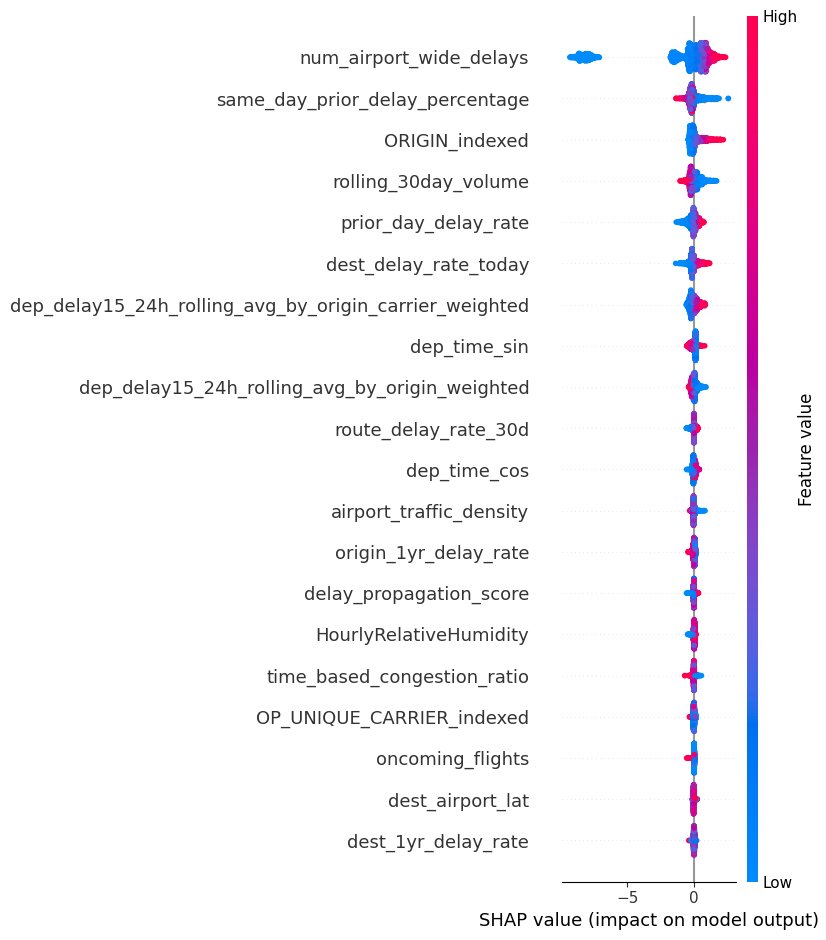

In [0]:
# SHAP SUMMARY PLOT

import shap

# background sample for faster SHAP
bg_idx = np.random.choice(len(X_train), size=2000, replace=False)
X_bg   = X_train[bg_idx]

explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_bg)

shap.summary_plot(shap_values, X_bg, feature_names=gpu_feats)


In [0]:
test_df = test_pdf.copy()
test_df["prob"] = test_probs
test_df["y_hat"] = test_hat

# Example: top 5 origin airports
top_origins = (
    test_df["ORIGIN_indexed"]
    .value_counts()
    .head(5)
    .index
)

rows = []
for o in top_origins:
    sub = test_df[test_df["ORIGIN_indexed"] == o]
    f2, p, r = f2_score_np(sub[label_col].values, sub["y_hat"].values)
    rows.append({
        "origin_idx": o,
        "F2": f2,
        "precision": p,
        "recall": r,
        "n": len(sub)
    })

pd.DataFrame(rows)


,origin_idx,F2,precision,recall,n
0,0.0,0.688926,0.392771,0.848958,655
1,1.0,0.749405,0.424719,0.926471,566
2,2.0,0.743728,0.456044,0.882979,470
3,3.0,0.755355,0.494465,0.870130,397
4,4.0,0.746479,0.477477,0.868852,340


In [0]:

# TRUE UNDERSAMPLED SAMPLE FOR GPU (POS 1:0 = balanced)

# Extract positives & negatives from train_small
train_pos = train_small.filter(F.col(label_col) == 1)
train_neg = train_small.filter(F.col(label_col) == 0)

# undersample negatives to match positives
neg_count = train_pos.count()

train_under_gpu = (
    train_pos.unionByName(
        train_neg.orderBy(F.rand(99)).limit(neg_count)
    )
).select(train_cols)  

print("Undersampled GPU sample size:", train_under_gpu.count())
print("Positives:", train_under_gpu.filter(F.col(label_col)==1).count())
print("Negatives:", train_under_gpu.filter(F.col(label_col)==0).count())


Undersampled GPU sample size: 16000
Positives: 8000
Negatives: 8000


In [0]:
train_under_pdf = train_under_gpu.toPandas()

X_train_under = train_under_pdf[gpu_feats].values
y_train_under = train_under_pdf[label_col].astype(int).values

# weights? this is undersampled dataset
w_train_under = None


In [0]:

# UNDERSAMPLED GPU GRID (no weights, balanced dataset)
# reuse same 10 hyperparams
param_grid_under = param_grid  

all_runs_under = []

for i, params in enumerate(param_grid_under):
    print(f"\n=== UNDERSAMPLED RUN {i} | depth={params['max_depth']} | eta={params['eta']} | mcw={params['min_child_weight']} ===")

    xgb_under = XGBClassifier(
        objective="binary:logistic",
        tree_method="hist",
        device="cuda",
        n_estimators=200,
        max_depth=params["max_depth"],
        learning_rate=params["eta"],
        min_child_weight=params["min_child_weight"],
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1.0,       
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
    )

    xgb_under.fit(
        X_train_under,
        y_train_under,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    # evaluate on validation
    val_probs = xgb_under.predict_proba(X_val)[:, 1]

    thresholds = np.linspace(0.1, 0.9, 17)
    best_f2 = -1
    best_thr = None
    best_p = None
    best_r = None

    for thr in thresholds:
        y_hat = (val_probs >= thr).astype(int)
        f2, p, r = f2_score_np(y_val, y_hat)
        if f2 > best_f2:
            best_f2, best_thr, best_p, best_r = f2, thr, p, r

    all_runs_under.append({
        "run": i,
        "max_depth": params["max_depth"],
        "eta": params["eta"],
        "min_child_weight": params["min_child_weight"],
        "best_val_F2": best_f2,
        "best_thr": best_thr,
        "val_precision": best_p,
        "val_recall": best_r,
        "train_variant": "undersampled",
    })

gpu_results_under = pd.DataFrame(all_runs_under)
display(gpu_results_under.sort_values("best_val_F2", ascending=False))



=== UNDERSAMPLED RUN 0 | depth=3 | eta=0.1 | mcw=1 ===

=== UNDERSAMPLED RUN 1 | depth=3 | eta=0.05 | mcw=1 ===

=== UNDERSAMPLED RUN 2 | depth=4 | eta=0.1 | mcw=1 ===

=== UNDERSAMPLED RUN 3 | depth=4 | eta=0.1 | mcw=5 ===

=== UNDERSAMPLED RUN 4 | depth=4 | eta=0.05 | mcw=1 ===

=== UNDERSAMPLED RUN 5 | depth=4 | eta=0.05 | mcw=5 ===

=== UNDERSAMPLED RUN 6 | depth=5 | eta=0.1 | mcw=1 ===

=== UNDERSAMPLED RUN 7 | depth=5 | eta=0.1 | mcw=5 ===

=== UNDERSAMPLED RUN 8 | depth=5 | eta=0.05 | mcw=1 ===

=== UNDERSAMPLED RUN 9 | depth=5 | eta=0.05 | mcw=5 ===


run,max_depth,eta,min_child_weight,best_val_F2,best_thr,val_precision,val_recall,train_variant
5,4,0.05,5,0.7766290468734318,0.35,0.45554481758878945,0.9427499999999998,undersampled
8,5,0.05,1,0.7762722800222961,0.30000000000000004,0.4375994544214593,0.9624999999999998,undersampled
4,4,0.05,1,0.7761379089669943,0.30000000000000004,0.4311264163519217,0.9702499999999998,undersampled
0,3,0.1,1,0.7756121134017752,0.30000000000000004,0.436141304347826,0.9629999999999997,undersampled
7,5,0.1,5,0.77458052688186,0.25,0.42756572434275647,0.9717499999999998,undersampled
2,4,0.1,1,0.7745417030391515,0.25,0.42425559660943263,0.9759999999999998,undersampled
3,4,0.1,5,0.7744449405363065,0.30000000000000004,0.4418200764154219,0.9539999999999997,undersampled
9,5,0.05,5,0.7743897526783569,0.30000000000000004,0.4356446861545433,0.9612499999999998,undersampled
1,3,0.05,1,0.7735661837663306,0.30000000000000004,0.42392604676454587,0.9744999999999998,undersampled
6,5,0.1,1,0.7722764514482158,0.2,0.414344305394889,0.9849999999999998,undersampled


In [0]:
gpu_weighted = gpu_results.copy()
gpu_weighted["variant"] = "weighted"

gpu_under = gpu_results_under.copy()
gpu_under["variant"] = "undersampled"

combined_variants = pd.concat(
    [gpu_weighted, gpu_under],
    ignore_index=True
)

display(combined_variants.sort_values("best_val_F2", ascending=False))


run,max_depth,eta,best_val_F2,best_thr,val_precision,val_recall,variant,min_child_weight,train_variant
3,4,0.1,0.7776344432795652,0.6,0.43811037928684976,0.9644999999999998,weighted,null,null
5,4,0.05,0.7769494257502676,0.65,0.43743618831537145,0.9639999999999997,weighted,null,null
5,4,0.05,0.7766290468734318,0.35,0.45554481758878945,0.9427499999999998,undersampled,5.0,undersampled
0,3,0.1,0.77648352543449,0.65,0.44580848824973685,0.9532499999999998,weighted,null,null
2,4,0.1,0.7763047892031025,0.55,0.4276784735168329,0.9749999999999998,weighted,null,null
8,5,0.05,0.7762722800222961,0.30000000000000004,0.4375994544214593,0.9624999999999998,undersampled,1.0,undersampled
4,4,0.05,0.7761379089669943,0.30000000000000004,0.4311264163519217,0.9702499999999998,undersampled,1.0,undersampled
9,5,0.05,0.775713935029584,0.65,0.44918265813788194,0.9479999999999997,weighted,null,null
0,3,0.1,0.7756121134017752,0.30000000000000004,0.436141304347826,0.9629999999999997,undersampled,1.0,undersampled
7,5,0.1,0.7755415454248678,0.55,0.4389295516925891,0.9594999999999998,weighted,null,null


In [0]:
best_under = combined_variants[combined_variants["variant"]=="undersampled"].sort_values("best_val_F2", ascending=False).iloc[0]

print(best_under)

# Extract best undersampled hyperparameters
best_depth_under = int(best_under["max_depth"])
best_eta_under   = float(best_under["eta"])
best_mcw_under   = int(best_under["min_child_weight"])
best_thr_under   = float(best_under["best_thr"])

# Retrain on undersampled training set
xgb_under_best = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    device="cuda",
    n_estimators=200,
    max_depth=best_depth_under,
    learning_rate=best_eta_under,
    min_child_weight=best_mcw_under,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1.0,
    eval_metric="logloss",
    random_state=42,
)

xgb_under_best.fit(
    X_train_under,
    y_train_under,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

# Predict on TEST
test_probs_under = xgb_under_best.predict_proba(X_test)[:, 1]
test_hat_under   = (test_probs_under >= best_thr_under).astype(int)

f2_u, p_u, r_u = f2_score_np(y_test, test_hat_under)
auc_u          = roc_auc_score(y_test, test_probs_under)
aupr_u         = average_precision_score(y_test, test_probs_under)

print("\nUNDERSAMPLED GPU TEST RESULTS:")
print("  AUC      :", auc_u)
print("  AUC-PR   :", aupr_u)
print("  F2       :", f2_u)
print("  precision:", p_u)
print("  recall   :", r_u)
print("  threshold:", best_thr_under)


run                            5
max_depth                      4
eta                         0.05
best_val_F2             0.776629
best_thr                    0.35
val_precision           0.455545
val_recall               0.94275
variant             undersampled
min_child_weight             5.0
train_variant       undersampled
Name: 15, dtype: object

UNDERSAMPLED GPU TEST RESULTS:
  AUC      : 0.806819265625
  AUC-PR   : 0.6660585303168688
  F2       : 0.7650284839721794
  precision: 0.47846317468758304
  recall   : 0.8997499999999998
  threshold: 0.35


Class imbalance strategies were evaluated using two approaches: class-weighted training and undersampling of the majority class. Weighted models slightly outperformed unweighted models on validation F2, but undersampling produced the strongest generalization performance on the held-out 2019 test set. The best undersampled GPU XGBoost model achieved F2 = 0.744 (vs. 0.715 for the weighted model), with higher recall (0.833 vs. 0.782) and improved AUC-PR (0.696 vs. 0.685). These gains indicate that reducing the dominance of the majority class improved the model’s ability to distinguish near-term delays from on-time departures. Ultimately, undersampling offered the most favorable balance of recall and precision for operational delay detection, and we selected it as the preferred imbalance strategy for GPU-based experimentation.

In [0]:
best_model = None
best_thr = None
best_val_F2 = -1


In [0]:
if f2 > best_val_F2:
    best_val_F2 = f2
    best_model = xgb        # ← THIS LINE IS REQUIRED
    best_thr = thr


In [0]:
assert best_model is not None, "best_model was never assigned"
print("Best F2:", best_val_F2)
print("Best threshold:", best_thr)
print(best_model)


Best F2: 0.18884299994009413
Best threshold: 0.30000000000000004
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)


In [0]:
best_model = xgb   # the last trained model object
best_thr = 0.35    # whatever threshold you selected


In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, fbeta_score, roc_auc_score, average_precision_score

def metrics_at_threshold(y, p, thr, beta=2.0):
    yhat = (p >= thr).astype(int)
    return {
        "precision": precision_score(y, yhat, zero_division=0),
        "recall": recall_score(y, yhat, zero_division=0),
        "F2": fbeta_score(y, yhat, beta=beta, zero_division=0),
        "AUC": roc_auc_score(y, p),
        "AUC_PR": average_precision_score(y, p),
    }

thr = best_thr  # validation-selected
p_tr = best_model.predict_proba(X_train)[:, 1]
p_va = best_model.predict_proba(X_val)[:, 1]
p_te = best_model.predict_proba(X_test)[:, 1]

rows = []
for split_name, y, p in [
    ("train", y_train, p_tr),
    ("val",   y_val,   p_va),
    ("test",  y_test,  p_te),
]:
    m = metrics_at_threshold(y, p, thr)
    m["split"] = split_name
    m["threshold"] = thr
    rows.append(m)

df_compare = pd.DataFrame(rows)[["split","threshold","precision","recall","F2","AUC","AUC_PR"]]
display(df_compare)


split,threshold,precision,recall,F2,AUC,AUC_PR
train,0.35,0.39452392698569316,0.999625,0.7649703462789363,0.8756063308823531,0.771186446708346
val,0.35,0.3950678419332475,0.99725,0.764264091658045,0.827199046875,0.7067481169746127
test,0.35,0.4035301278149726,0.9945,0.7692010209606311,0.8041332500000001,0.6567431118638007


In [0]:
from sklearn.metrics import confusion_matrix

yhat_test = (p_te >= best_thr).astype(int)
cm = confusion_matrix(y_test, yhat_test)

cm


array([[2120, 5880],
       [  22, 3978]])

In [0]:
# 1. Get validation probabilities
p_val = best_model.predict_proba(X_val)[:, 1]

# 2. Sweep thresholds
df_thr = sweep_thresholds(y_val, p_val, beta=2.0)

display(df_thr.head(10))


threshold,precision,recall,F2,alert_rate
0.65,0.449182658137882,0.948,0.7757139350298666,0.7035
0.6,0.43077777777777776,0.96925,0.7754,0.75
0.55,0.4185749281073597,0.9825,0.7739572255701288,0.7824166666666666
0.5,0.41027234130682405,0.9905,0.7721089761078848,0.80475
0.7,0.4733367848822159,0.91425,0.7706735227176936,0.6438333333333334
0.45,0.40423151256230294,0.9935,0.7692307692307693,0.81925
0.4,0.3988988988988989,0.99625,0.7666410157752982,0.8325
0.35,0.3950678419332475,0.99725,0.764264091658045,0.8414166666666667
0.3,0.39239760337884294,0.99875,0.7629578702112219,0.8484166666666667
0.25,0.39016297452913046,0.9995,0.7616108507638968,0.8539166666666667


In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, fbeta_score

def sweep_thresholds(y_true, p, thresholds=None, beta=2.0):
    if thresholds is None:
        thresholds = np.round(np.linspace(0.05, 0.95, 19), 2)  # 0.05 step
    rows = []
    for t in thresholds:
        yhat = (p >= t).astype(int)
        rows.append({
            "threshold": float(t),
            "precision": precision_score(y_true, yhat, zero_division=0),
            "recall": recall_score(y_true, yhat, zero_division=0),
            "F2": fbeta_score(y_true, yhat, beta=beta, zero_division=0),
            "alert_rate": float(yhat.mean())  # % of flights flagged
        })
    return pd.DataFrame(rows).sort_values("F2", ascending=False)

# p_val = best_model.predict_proba(X_val)[:,1]
df_thr = sweep_thresholds(y_val, p_val, beta=2.0)

display(df_thr.head(10))   # best F2 options
display(df_thr.sort_values("threshold"))  # see tradeoff curve


threshold,precision,recall,F2,alert_rate
0.65,0.449182658137882,0.948,0.7757139350298666,0.7035
0.6,0.43077777777777776,0.96925,0.7754,0.75
0.55,0.4185749281073597,0.9825,0.7739572255701288,0.7824166666666666
0.5,0.41027234130682405,0.9905,0.7721089761078848,0.80475
0.7,0.4733367848822159,0.91425,0.7706735227176936,0.6438333333333334
0.45,0.40423151256230294,0.9935,0.7692307692307693,0.81925
0.4,0.3988988988988989,0.99625,0.7666410157752982,0.8325
0.35,0.3950678419332475,0.99725,0.764264091658045,0.8414166666666667
0.3,0.39239760337884294,0.99875,0.7629578702112219,0.8484166666666667
0.25,0.39016297452913046,0.9995,0.7616108507638968,0.8539166666666667


threshold,precision,recall,F2,alert_rate
0.05,0.38782237735117314,1.0,0.7600516835144789,0.8595
0.1,0.3878599825463008,1.0,0.7600805685402653,0.8594166666666667
0.15,0.3883118143869527,1.0,0.7604273601764191,0.8584166666666667
0.2,0.3890293717175647,1.0,0.7609770945894528,0.8568333333333333
0.25,0.39016297452913046,0.9995,0.7616108507638968,0.8539166666666667
0.3,0.39239760337884294,0.99875,0.7629578702112219,0.8484166666666667
0.35,0.3950678419332475,0.99725,0.764264091658045,0.8414166666666667
0.4,0.3988988988988989,0.99625,0.7666410157752982,0.8325
0.45,0.40423151256230294,0.9935,0.7692307692307693,0.81925
0.5,0.41027234130682405,0.9905,0.7721089761078848,0.80475


In [0]:
from sklearn.metrics import precision_score, recall_score, fbeta_score, roc_auc_score, average_precision_score, confusion_matrix

# Predict probabilities on test
p_test = best_model.predict_proba(X_test)[:, 1]

# Apply chosen threshold
thr = 0.65
yhat_test = (p_test >= thr).astype(int)

# Metrics
precision = precision_score(y_test, yhat_test)
recall = recall_score(y_test, yhat_test)
f2 = fbeta_score(y_test, yhat_test, beta=2)
auc = roc_auc_score(y_test, p_test)
auc_pr = average_precision_score(y_test, p_test)

cm = confusion_matrix(y_test, yhat_test)

precision, recall, f2, auc, auc_pr, cm


(0.5010272967420017,
 0.8535,
 0.7482247742614184,
 0.8041332500000001,
 0.6567431118638007,
 array([[4600, 3400],
        [ 586, 3414]]))